### INITIALIZATION

In [21]:
# Import external libraries:
import numpy as np
import skfem as sk
import matplotlib.pyplot as plt

# Import external functions:
from skfem.helpers import dot, grad
from scipy.sparse.linalg import splu
from skfem.visuals.matplotlib import plot

In [23]:
# Define problem size:
H = 200 # [cm] core length
L = 120 # [cm] heat-exchanger length

# Define region identifier:
reg_H = lambda x: (x>=0) * (x<H)    # Core region identifier
reg_L = lambda x: (x>=H) * (x<H+L)  # Heat-exchanger identifier

# Define problem parameters:
a_T_temp, a_H_temp, a_L_temp =  0.0, -0.1,  0.1  # Reaction parameters   [1/s]
b_T_temp, b_H_temp, b_L_temp =  0.5,  0.0,  0.0  # Diffusion parameters  [cm^2/s]
c_T_temp, c_H_temp, c_L_temp =  1.0,  0.0,  0.0  # Advection parameters  [cm/s]

# Define time discretization
dt = 0.0025         # Time step width [s]
theta = 0.00        # Define integration scheme: 0.0 -> implicit, 0.5 -> Crank-Nicolson, 1.0 -> explicit
alpha = 1e-2        # Define stabilization of discontinuous Galerkin:
time_steps = 40000  # Number of time steps [-]

# Define mesh discretization
mesh_steps = 160               # Number of spatial mesh intervals [-]
mesh_width = (H+L)/mesh_steps  # Mesh element width [cm]
mash_nodes = np.linspace(0, H+L+mesh_width, mesh_steps+2)

### DISCONTINUOUS GALERKIN

#### Define problem bilinear forms

In [27]:
# Define global mass bilinear form:
@sk.BilinearForm 
def mass_dgi_T(u, v, _): return u * v

# Define mass bilinear form on the core region:
@sk.BilinearForm
def mass_dgi_H(u, v, w): return reg_H(w.x[0]) * u * v

# Define mass bilinear form on the heat-exchanger region:
@sk.BilinearForm
def mass_dgi_L(u, v, w): return reg_L(w.x[0]) * u * v

# Define global diffusion bilinear form:
@sk.BilinearForm
def diffusion_dgi_T(u, v, _): return dot(grad(u), grad(v))

# Define discontinuous Galerkin boundary term for the diffusion bilinear form:
@sk.BilinearForm
def diffusion_dgf_T(u1, u2, v1, v2, w): return - (v1-v2)*(grad(u1)[0]+grad(u2)[0])*w.n[0]/2 + (v1-v2)*(u1-u2)/(alpha*mesh_width)

# Define advection bilinear form for discontinuous Galerkin:
@sk.BilinearForm
def advection_dgi_T(u, v, _): return - u * grad(v)[0]

# Define discontinuous Galerkin boundary term for the advection bilinear form:
@sk.BilinearForm
def advection_dgf_T(u1, u2, v1, v2, w): return (v1-v2)*(u1*w.n[0]+u2*w.n[0])*np.ones(w.n[0].shape)/2 + (v1-v2)*(u1-u2)/(alpha*mesh_width)

#### Define mathod to convert matrices defined on a simple domain to a periodic domain

In [30]:
 # Convert facet discontinuous Galerkin matrix to periodic form:
def periodic_matrix_dg_f(matrix):
    matrix[:2, :] += matrix[-2:, :]
    matrix[:, :2] += matrix[:, -2:]
    return matrix[:, :-2][:-2, :]

# Convert interior dicontinuous Galerkin matrix to periodic form:
def periodic_matrix_dg_i(matrix):
    return matrix[:, :-2][:-2, :]

#### Assemble all the matrices and the vectors needed for the solution of a RAD problem:

In [36]:
# Define discontinuous Galerkin interior and facet basis:
line_mesh_periodic_dg = sk.MeshLine(mash_nodes)
line_element_dg = sk.element.ElementDG(sk.element.ElementLineP1())
line_basis_dg_i = sk.Basis(line_mesh_periodic_dg, line_element_dg)
line_basis_dg_f = sk.InteriorFacetBasis(line_mesh_periodic_dg, line_element_dg, side=0) @ sk.InteriorFacetBasis(line_mesh_periodic_dg, line_element_dg, side=1)

# Assemble reaction term matrices for discontinuous Galerkin problem:
MM_T_1D_dg_i = periodic_matrix_dg_i(mass_dgi_T.assemble(line_basis_dg_i))
MM_H_1D_dg_i = periodic_matrix_dg_i(mass_dgi_H.assemble(line_basis_dg_i))
MM_L_1D_dg_i = periodic_matrix_dg_i(mass_dgi_L.assemble(line_basis_dg_i))

# Define advection and diffusion matrices for discontinuous Galerkin problem:
KK_T_1D_dg_f = periodic_matrix_dg_f(diffusion_dgf_T.assemble(line_basis_dg_f))
CC_T_1D_dg_f = periodic_matrix_dg_f(advection_dgf_T.assemble(line_basis_dg_f))
KK_T_1D_dg_i = periodic_matrix_dg_i(diffusion_dgi_T.assemble(line_basis_dg_i))
CC_T_1D_dg_i = periodic_matrix_dg_i(advection_dgi_T.assemble(line_basis_dg_i))

# Define initial conditions:
x_dg = np.concatenate([mash_nodes[ii:ii+2] for ii in range(mesh_steps)])
y_dg = [(x_dg[ii]<35)*(x_dg[ii]>=0)*(x_dg[ii]/35) + (x_dg[ii]<70)*(x_dg[ii]>=35)*(1-(x_dg[ii]-35)/35) for ii in range(len(x_dg))]
z_dg = sk.solve(0.001 * MM_T_1D_dg_i + KK_T_1D_dg_i + KK_T_1D_dg_f, MM_T_1D_dg_i.dot(y_dg))

# Define left and right hand side of the discontinuous Galerkin problem:
SS_all_dg = a_H_temp * MM_H_1D_dg_i + a_L_temp * MM_L_1D_dg_i + b_T_temp * (KK_T_1D_dg_i + KK_T_1D_dg_f) + c_T_temp * (CC_T_1D_dg_i + CC_T_1D_dg_f)
AA_all_dg = MM_T_1D_dg_i +      theta  * SS_all_dg * dt
BB_all_dg = MM_T_1D_dg_i - (1 - theta) * SS_all_dg * dt

#### Solve problem in time

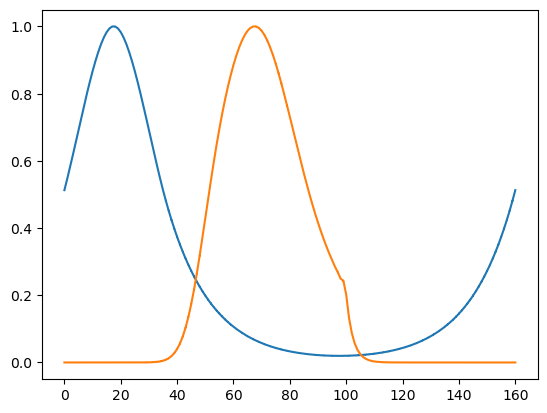

In [39]:
# Initialise solution nd-array:
solution_dg = np.ones((AA_all_dg.shape[0], time_steps+1))
solution_dg[:, 0] = z_dg

# Iteratively solve problem:
backsolve_dg = splu(AA_all_dg.T).solve
for ii in range(time_steps):
    solution_dg[:, ii+1] = backsolve_dg(BB_all_dg @ solution_dg[:, ii])

# Plot the solution at the initial and at the finial time:
plt.plot([ii//2 for ii in range(1, 2*mesh_steps+1)], solution_dg[:,  0] / max(solution_dg[:,  0]))
plt.plot([ii//2 for ii in range(1, 2*mesh_steps+1)], solution_dg[:, -1] / max(solution_dg[:, -1]))
plt.show()